# Objective

- This project aims to predict the potential success of movies by forecasting their revenue using key movie attributes. This is a regression problem where the target variable is `revenue`, and predictors include budget, genres, cast, audience and critic scores, and more.

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
# Import necessary libraries
from transformers import AutoTokenizer, AutoModel
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.utils import to_categorical


# Load the Data

## Data Sources

In this study, we utilize four primary data sources to build a comprehensive dataset for analysis:

1. **Movie Dataset**:
   - **Source**: Kaggle.
   - **Description**: Contains foundational movie data including basic attributes like titles, release dates, box office figures, and other metadata.

2. **Rotten Data**:
   - **Source**: Rotten Tomatoes API.
   - **Description**: Scraped audience and critic scores from Rotten Tomatoes to incorporate external popularity and review metrics.

3. **Movies with Actors**:
   - **Source**: IMDb.
   - **Description**: Includes movie names, genres, and cast details. This dataset is primarily used to fill in missing values for genres and cast information in the `movie_dataset`.

4. **Cast Popularity**:
   - **Source**: IMDb.
   - **Description**: Provides weighted average ratings for each cast member based on their past movie performances. This dataset is merged with `movie_dataset` to include director popularity scores and cast-related metrics in the analysis.

---

In [2]:
movies_data = pd.read_csv('movie_dataset.csv')
rotten_data = pd.read_csv('rotten_tomatoes_movie_ratings_output.csv', sep='\t', on_bad_lines='skip')
movies_with_actors = pd.read_csv('movies_with_actors.csv')
cast_popularity = pd.read_csv('cast_popularity.csv')


# Merging the datasets on 'id'
merged_df = pd.merge(movies_data, rotten_data, on='id', how='left')

In [3]:
# Binary flag for homepage presence
merged_df['has_homepage'] = merged_df['homepage'].apply(lambda x: 1 if isinstance(x, str) and len(x) > 0 else 0)
# Feature Engineering
merged_df['release_year'] = pd.to_datetime(merged_df['release_date'], errors='coerce').dt.year

In [4]:
movies = merged_df[['id','Movie Name','budget','genres','has_homepage','original_language',
                    'original_title','overview','release_year','runtime',
                    'cast', 'production_companies','production_countries','director',
                    'keywords','Audience Score',
                    'Critic Score','revenue']].copy()

# Visualizations

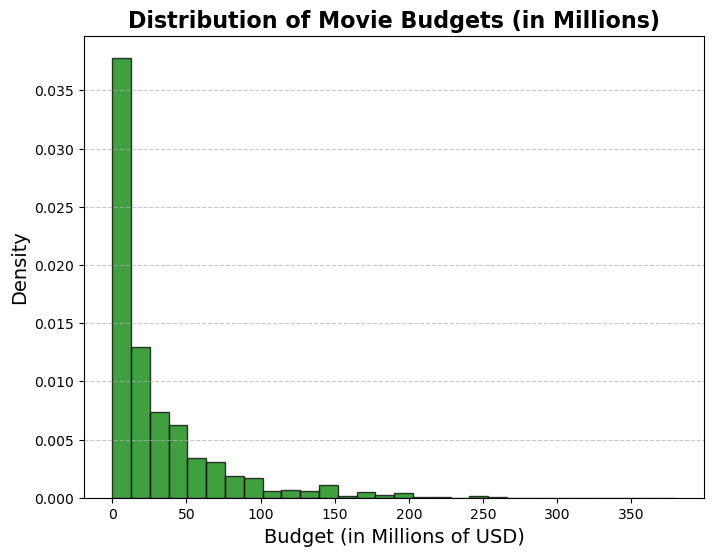

Minimum Budget: $0.00 million
Maximum Budget: $380.00 million
Average Budget: $29.05 million
Variance of Budgets: $1,657.97 million²


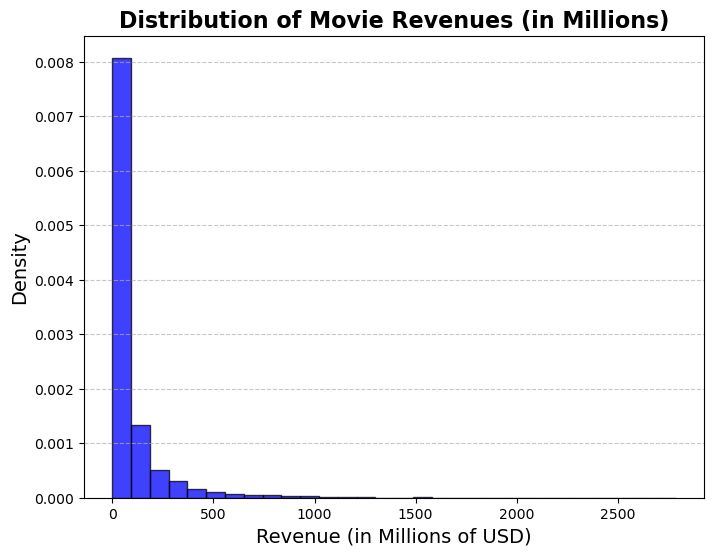

Minimum Revenue: $0.00 million
Maximum Revenue: $2,787.97 million
Average Revenue: $82.26 million
Variance of Revenues: $26,516.91 million²


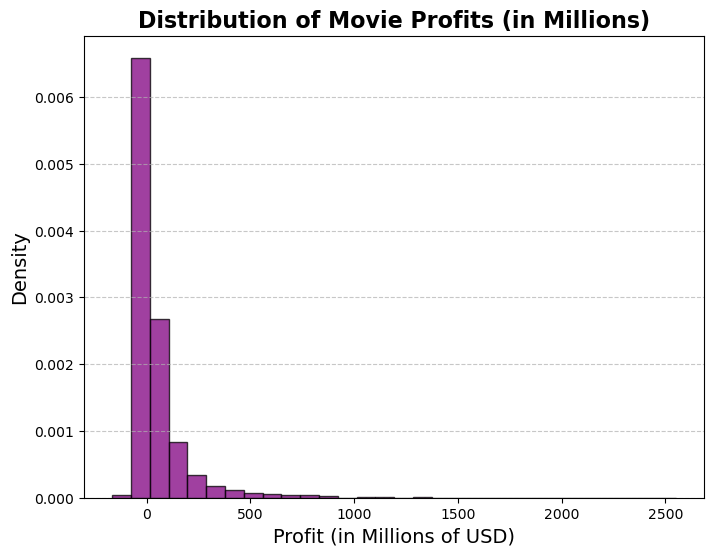

Minimum Profit: $-165.71 million
Maximum Profit: $2,550.97 million
Average Profit: $53.22 million
Variance of Profits: $18,483.37 million²


In [5]:

# Calculate budget, revenue, and profit in millions
movies['budget_millions'] = movies['budget'] / 1e6
movies['revenue_millions'] = movies['revenue'] / 1e6
movies['profit_millions'] = (movies['revenue'] - movies['budget']) / 1e6

# Plot the histogram for Budget
plt.figure(figsize=(8, 6))
plt.hist(movies['budget_millions'], bins=30, density=True, color='green', alpha=0.75, edgecolor='black')
plt.xlabel('Budget (in Millions of USD)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Movie Budgets (in Millions)', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('budget_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical Summary for Budget
min_budget = np.min(movies['budget_millions'])
max_budget = np.max(movies['budget_millions'])
mean_budget = np.mean(movies['budget_millions'])
variance_budget = np.var(movies['budget_millions'])

print(f"Minimum Budget: ${min_budget:,.2f} million")
print(f"Maximum Budget: ${max_budget:,.2f} million")
print(f"Average Budget: ${mean_budget:,.2f} million")
print(f"Variance of Budgets: ${variance_budget:,.2f} million²")

# Plot the histogram for Revenue
plt.figure(figsize=(8, 6))
plt.hist(movies['revenue_millions'], bins=30, density=True, color='blue', alpha=0.75, edgecolor='black')
plt.xlabel('Revenue (in Millions of USD)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Movie Revenues (in Millions)', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('revenue_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical Summary for Revenue
min_revenue = np.min(movies['revenue_millions'])
max_revenue = np.max(movies['revenue_millions'])
mean_revenue = np.mean(movies['revenue_millions'])
variance_revenue = np.var(movies['revenue_millions'])

print(f"Minimum Revenue: ${min_revenue:,.2f} million")
print(f"Maximum Revenue: ${max_revenue:,.2f} million")
print(f"Average Revenue: ${mean_revenue:,.2f} million")
print(f"Variance of Revenues: ${variance_revenue:,.2f} million²")

# Plot the histogram for Profit
plt.figure(figsize=(8, 6))
plt.hist(movies['profit_millions'], bins=30, density=True, color='purple', alpha=0.75, edgecolor='black')
plt.xlabel('Profit (in Millions of USD)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Movie Profits (in Millions)', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('profit_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical Summary for Profit
min_profit = np.min(movies['profit_millions'])
max_profit = np.max(movies['profit_millions'])
mean_profit = np.mean(movies['profit_millions'])
variance_profit = np.var(movies['profit_millions'])

print(f"Minimum Profit: ${min_profit:,.2f} million")
print(f"Maximum Profit: ${max_profit:,.2f} million")
print(f"Average Profit: ${mean_profit:,.2f} million")
print(f"Variance of Profits: ${variance_profit:,.2f} million²")


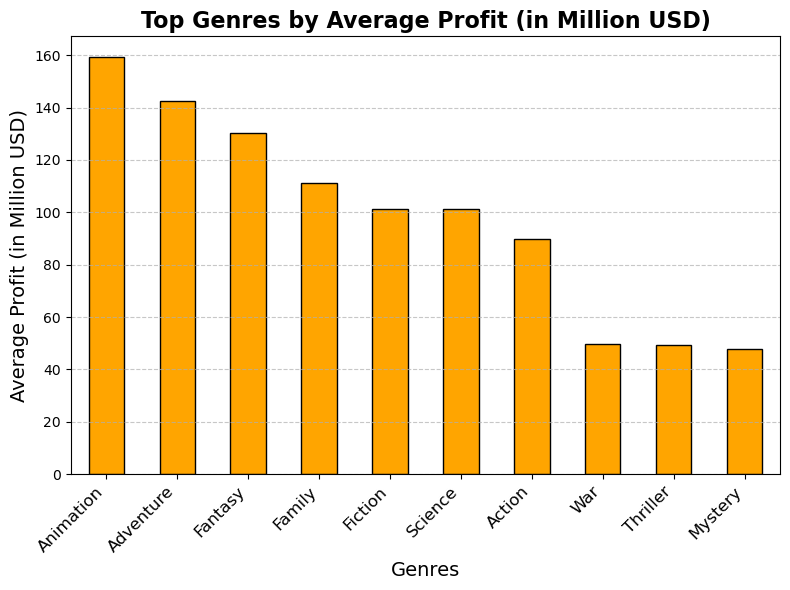

In [6]:
def compute_genre_profits(row):
    genres = row['genres'].split() if isinstance(row['genres'], str) else []
    profit = row['revenue'] - row['budget']
    return [(genre, profit) for genre in genres]

# Compute a list of tuples (genre, profit) for all rows
genre_profit_pairs = movies.apply(compute_genre_profits, axis=1).explode()

# Drop NaN values in genre_profit_pairs
genre_profit_pairs = genre_profit_pairs.dropna()

# Convert to a DataFrame
genre_profit_df = pd.DataFrame(genre_profit_pairs.tolist(), columns=['genre', 'profit'])

# Group by genre and calculate the average profit
average_profit_by_genre = genre_profit_df.groupby('genre')['profit'].mean().sort_values(ascending=False)

# Convert profits to millions of dollars
average_profit_by_genre /= 1e6

# Select top 10 genres by average profit
top_genres_profit = average_profit_by_genre.head(10)

# Plot the results
plt.figure(figsize=(8, 6))
top_genres_profit.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top Genres by Average Profit (in Million USD)', fontsize=16, fontweight='bold')
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Average Profit (in Million USD)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('genres_budget_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

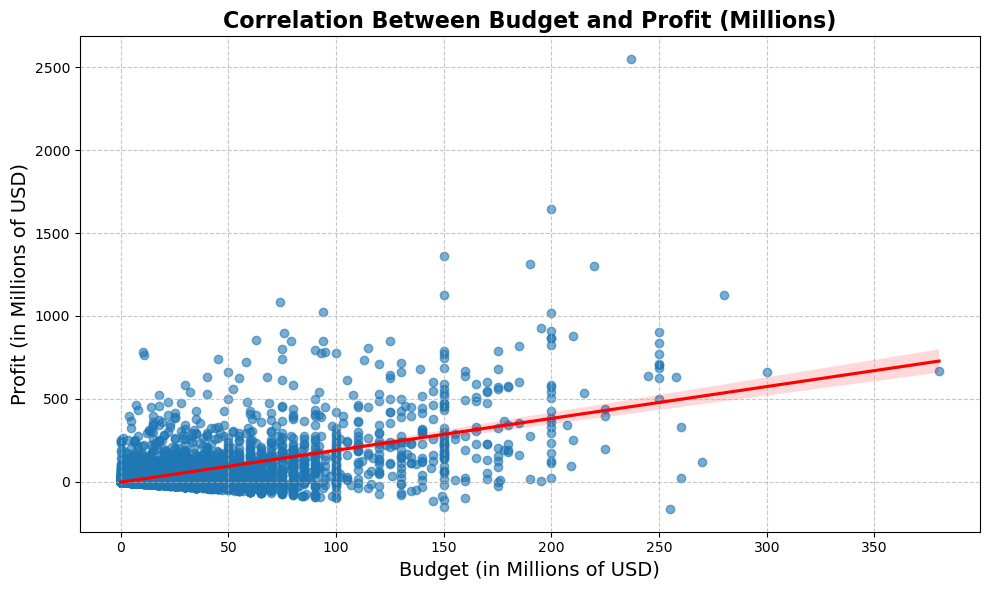

In [7]:

# Calculate profit for each movie in millions
movies['profit_millions'] = (movies['revenue'] - movies['budget']) / 1e6
movies['budget_millions'] = movies['budget'] / 1e6

# Calculate correlation coefficient
correlation_coefficient = movies[['budget_millions', 'profit_millions']].corr().iloc[0, 1]

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='budget_millions', y='profit_millions', data=movies, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})

# Add title and labels
plt.title(f'Correlation Between Budget and Profit (Millions)', fontsize=16, fontweight='bold')
plt.xlabel('Budget (in Millions of USD)', fontsize=14)
plt.ylabel('Profit (in Millions of USD)', fontsize=14)

# Display the plot
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('profit_budget_correlation.png', dpi=300, bbox_inches='tight')

plt.show()


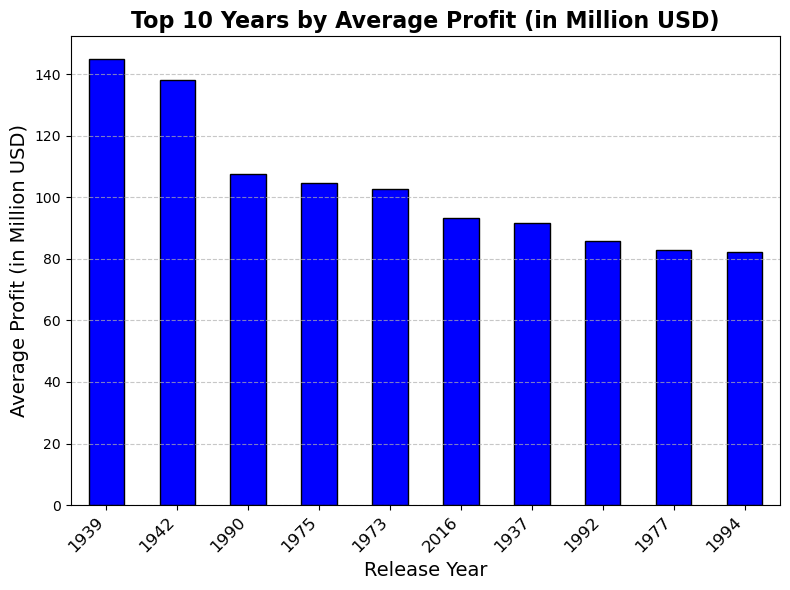

In [8]:
# Calculate profit column if not already present
movies['profit'] = movies['revenue'] - movies['budget']

# Group by release year and calculate the average profit
average_profit_by_year = movies.groupby('release_year')['profit'].mean().sort_values(ascending=False)

# Convert profits to millions of dollars
average_profit_by_year /= 1e6

# Select top 10 years by average profit
top_years_profit = average_profit_by_year.head(10)

# Convert the index (release year) to integers for better representation
top_years_profit.index = top_years_profit.index.astype(int)

# Plot the results
plt.figure(figsize=(8, 6))
top_years_profit.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Top 10 Years by Average Profit (in Million USD)', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Profit (in Million USD)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('profit_by_year_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## Pre-Proccessing

In [9]:

## changing the production_companies column from json to string
movies['production_companies']=movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1=[]
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies']=str(list1)
    
# changing the production_countries column from json to string    
movies['production_countries']=movies['production_countries'].apply(json.loads)
for index,i in zip(movies.index,movies['production_countries']):
    list1=[]
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_countries']=str(list1)
    


## Remove Rows with NaN Values in Essential Features

In [10]:
# Replace Nan Critic Score with Audience Score
movies.loc[movies['Critic Score'].isna(),'Critic Score']= movies.loc[movies['Critic Score'].isna(),'Audience Score']


movies.dropna(subset=['Critic Score','release_year','overview' ], inplace=True)


In [11]:
print(movies.isna().sum())
print(len(movies))

id                        0
Movie Name                0
budget                    0
genres                   11
has_homepage              0
original_language         0
original_title            0
overview                  0
release_year              0
runtime                   0
cast                     18
production_companies      0
production_countries      0
director                 11
keywords                267
Audience Score           11
Critic Score              0
revenue                   0
budget_millions           0
revenue_millions          0
profit_millions           0
profit                    0
dtype: int64
3516


# Imdb Data 

### Use IMDB data to fill the missing values in genre and cast 

In [12]:
movies_imdb = pd.merge(movies, movies_with_actors[['originalTitle', 'startYear',
       'runtimeMinutes', 'genres', 'primaryName']], left_on=['original_title', 'release_year','runtime'],
                  right_on=['originalTitle', 'startYear','runtimeMinutes'], how='left')
movies_imdb['genres'] = movies_imdb['genres_x'].combine_first(movies_imdb['genres_y'])

# Standardize 'genres' column formatting (convert comma-separated strings into lists and back)
def clean_genres(genres):
    if isinstance(genres, str):
        return ', '.join(sorted(set(genres.split(','))))
    return None

movies_imdb['genres'] = movies_imdb['genres'].apply(clean_genres)



# Function to clean the primaryName column
def clean_cast_string(names):
    if isinstance(names, str):  # Ensure the input is a string
        return names.strip('[]').replace("'", "").replace(',', '').strip('[]')
    return None  # Return None for invalid or missing data


movies_imdb['cast_filled'] = movies_imdb['primaryName'].apply(clean_cast_string)

# 5. Fill missing cast values
movies_imdb['cast'] = movies_imdb['cast'].combine_first(movies_imdb['cast_filled'])
movies_imdb


,id,Movie Name,budget,genres_x,has_homepage,original_language,original_title,overview,release_year,runtime,...,revenue_millions,profit_millions,profit,originalTitle,startYear,runtimeMinutes,genres_y,primaryName,genres,cast_filled
0,19995,Avatar,237000000,Action Adventure Fantasy Science Fiction,1,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",2009.0,162.0,...,2787.965087,2550.965087,2550965087,Avatar,2009.0,162.0,"Action,Adventure,Fantasy","['James Horner', 'James Cameron', 'Sigourney W...",Action Adventure Fantasy Science Fiction,James Horner James Cameron Sigourney Weaver Gi...
1,285,Pirates of the Caribbean: At World's End,300000000,Adventure Fantasy Action,1,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",2007.0,169.0,...,961.000000,661.000000,661000000,Pirates of the Caribbean: At World's End,2007.0,169.0,"Action,Adventure,Fantasy","['Johnny Depp', 'Jerry Bruckheimer', 'Charles ...",Adventure Fantasy Action,Johnny Depp Jerry Bruckheimer Charles Gibson T...
2,206647,Spectre,245000000,Action Adventure Crime,1,en,Spectre,A cryptic message from Bond’s past sends him o...,2015.0,148.0,...,880.674609,635.674609,635674609,Spectre,2015.0,148.0,"Action,Adventure,Thriller","['Alfonso Esparza Oteo', 'Chuck Aaron', 'Ignac...",Action Adventure Crime,Alfonso Esparza Oteo Chuck Aaron Ignacio Artea...
3,49026,The Dark Knight Rises,250000000,Action Crime Drama Thriller,1,en,The Dark Knight Rises,Following the death of District Attorney Harve...,2012.0,165.0,...,1084.939099,834.939099,834939099,NaN,NaN,NaN,NaN,NaN,Action Crime Drama Thriller,None
4,49529,John Carter,260000000,Action Adventure Science Fiction,1,en,John Carter,"John Carter is a war-weary, former military ca...",2012.0,132.0,...,284.139100,24.139100,24139100,John Carter,2012.0,132.0,"Action,Adventure,Sci-Fi","['Melissa Moseley', 'Michael Aarvold', 'Myriam...",Action Adventure Science Fiction,Melissa Moseley Michael Aarvold Myriam Acharki...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,14337,Primer,7000,Science Fiction Drama Thriller,1,en,Primer,Friends/fledgling entrepreneurs invent a devic...,2004.0,77.0,...,0.424760,0.417760,417760,Primer,2004.0,77.0,"Drama,Sci-Fi,Thriller","['Anand Upadhyaya', 'James Russell', 'Samantha...",Science Fiction Drama Thriller,Anand Upadhyaya James Russell Samantha Thomson...
3513,9367,El Mariachi,220000,Action Crime Thriller,0,es,El Mariachi,El Mariachi just wants to play his guitar and ...,1992.0,81.0,...,2.040920,1.820920,1820920,NaN,NaN,NaN,NaN,NaN,Action Crime Thriller,None
3514,72766,Newlyweds,9000,Comedy Romance,0,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,2011.0,85.0,...,0.000000,-0.009000,-9000,NaN,NaN,NaN,NaN,NaN,Comedy Romance,None
3515,126186,Shanghai Calling,0,NaN,1,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,2012.0,98.0,...,0.000000,0.000000,0,NaN,NaN,NaN,NaN,NaN,None,None


In [13]:
movies_imdb = movies_imdb[['id', 'genres', 'Movie Name', 'budget', 'has_homepage',
       'original_language', 'original_title', 'overview', 'release_year',
       'runtime', 'cast', 'production_companies', 'production_countries',
       'director', 'keywords', 'Audience Score', 'Critic Score', 'revenue','primaryName','profit' ]].copy()

In [14]:
print(movies_imdb.isna().sum())
print(len(movies_imdb))

id                        0
genres                    5
Movie Name                0
budget                    0
has_homepage              0
original_language         0
original_title            0
overview                  0
release_year              0
runtime                   0
cast                      7
production_companies      0
production_countries      0
director                 11
keywords                267
Audience Score           11
Critic Score              0
revenue                   0
primaryName             820
profit                    0
dtype: int64
3517


### Drop a few rows that have no information director, cast, and generes

In [15]:
movies_imdb.dropna(subset=['director' ,'cast','genres'], inplace=True)

In [16]:
print(movies_imdb.isna().sum())
print(len(movies_imdb))

id                        0
genres                    0
Movie Name                0
budget                    0
has_homepage              0
original_language         0
original_title            0
overview                  0
release_year              0
runtime                   0
cast                      0
production_companies      0
production_countries      0
director                  0
keywords                254
Audience Score           11
Critic Score              0
revenue                   0
primaryName             806
profit                    0
dtype: int64
3497


### Use IMDB Data to Add One New Features for Director Popularity 

In [17]:
cast_popularity.columns = ['director', 'director_pop']

In [18]:
cast_popularity

,director,director_pop
0,'Amarillo Slim' Preston,7.074049
1,'Atlas' Ramachandran,7.315633
2,'Baby' Carmen De Rue,5.696813
3,'Baby' Paul Cullen,7.600000
4,'Beatle' Bob Matonis,7.300000
...,...,...
433172,Þórhildur Þorleifsdóttir,7.200000
433173,Þórir Waagfjörð,5.200000
433174,Þórunn Lárusdóttir,8.500000
433175,Þórunn Magnea Magnúsdóttir,6.772005


In [19]:
movies_imdb = pd.merge(movies_imdb, cast_popularity, left_on=['director'],
                  right_on=['director'], how='left')

In [20]:
print(movies_imdb.isna().sum())
print(len(movies_imdb))

id                        0
genres                    0
Movie Name                0
budget                    0
has_homepage              0
original_language         0
original_title            0
overview                  0
release_year              0
runtime                   0
cast                      0
production_companies      0
production_countries      0
director                  0
keywords                254
Audience Score           11
Critic Score              0
revenue                   0
primaryName             806
profit                    0
director_pop            635
dtype: int64
3497


## Impute missing values in numerical column of runtime and director popularity

In [21]:
numeric_columns = ['runtime','director_pop']
imputer = SimpleImputer(strategy='median')
movies_imdb[numeric_columns] = imputer.fit_transform(movies_imdb[numeric_columns])

In [22]:
print(movies_imdb.isna().sum())
print(len(movies_imdb))

id                        0
genres                    0
Movie Name                0
budget                    0
has_homepage              0
original_language         0
original_title            0
overview                  0
release_year              0
runtime                   0
cast                      0
production_companies      0
production_countries      0
director                  0
keywords                254
Audience Score           11
Critic Score              0
revenue                   0
primaryName             806
profit                    0
director_pop              0
dtype: int64
3497


# Prepare Data For Model

In [23]:
movies_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3497 non-null   int64  
 1   genres                3497 non-null   object 
 2   Movie Name            3497 non-null   object 
 3   budget                3497 non-null   int64  
 4   has_homepage          3497 non-null   int64  
 5   original_language     3497 non-null   object 
 6   original_title        3497 non-null   object 
 7   overview              3497 non-null   object 
 8   release_year          3497 non-null   float64
 9   runtime               3497 non-null   float64
 10  cast                  3497 non-null   object 
 11  production_companies  3497 non-null   object 
 12  production_countries  3497 non-null   object 
 13  director              3497 non-null   object 
 14  keywords              3243 non-null   object 
 15  Audience Score       

In [24]:
movies_imdb['Critic Score'] = movies_imdb['Critic Score'].str.rstrip('%').astype(float)

### Remove rows that have 0 for budget and revenue

In [25]:
movies_imdb = movies_imdb[~((movies_imdb['revenue']==0) | (movies_imdb['budget']==0))].reset_index(drop=True).copy()

In [26]:
### Extract numerical and categorical features

In [27]:

# One-hot encode 'genres'
# Split genres into lists for MultiLabelBinarizer
movies_imdb['genres_split'] = movies_imdb['genres'].str.split()  # Convert genres into lists
mlb = MultiLabelBinarizer()
genres_one_hot = pd.DataFrame(mlb.fit_transform(movies_imdb['genres_split']),
                              columns=mlb.classes_,
                              index=movies_imdb.index)

# Drop the intermediate 'genres_split' column (optional)
movies_imdb.drop('genres_split', axis=1, inplace=True)

# One-hot encode 'original_language'
ohe = OneHotEncoder(sparse_output=False, dtype=int)
language_one_hot = pd.DataFrame(ohe.fit_transform(movies_imdb[['original_language']]),
                                columns=ohe.get_feature_names_out(['original_language']),
                                index=movies_imdb.index)

# Concatenate the one-hot encoded data back into the original dataframe
movies_imdb_one_hot = pd.concat([genres_one_hot, language_one_hot], axis=1)



In [28]:
numerical_data = movies_imdb[['budget','release_year','runtime', 'Critic Score','director_pop']].copy()
categorical = pd.concat([movies_imdb[['has_homepage']].copy(), movies_imdb_one_hot], axis=1)

In [29]:
categorical

,has_homepage,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,original_language_es,original_language_fr,original_language_hi,original_language_it,original_language_ko,original_language_nb,original_language_nl,original_language_pl,original_language_te,original_language_zh
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2450,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2451,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2452,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
numerical_data

,budget,release_year,runtime,Critic Score,director_pop
0,237000000,2009.0,162.0,81.0,7.946985
1,300000000,2007.0,169.0,43.0,7.651340
2,245000000,2015.0,148.0,44.0,7.870266
3,250000000,2012.0,165.0,87.0,8.570844
4,260000000,2012.0,132.0,52.0,8.070886
...,...,...,...,...,...
2449,31192,2009.0,89.0,86.0,6.273766
2450,27000,1994.0,92.0,90.0,7.405388
2451,12000,1972.0,93.0,84.0,5.765007
2452,7000,2004.0,77.0,72.0,6.331930


In [31]:
numerical_data.isna().sum()

budget          0
release_year    0
runtime         0
Critic Score    0
director_pop    0
dtype: int64

In [32]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   has_homepage          2454 non-null   int64
 1   Action                2454 non-null   int32
 2   Adventure             2454 non-null   int32
 3   Animation             2454 non-null   int32
 4   Comedy                2454 non-null   int32
 5   Crime                 2454 non-null   int32
 6   Documentary           2454 non-null   int32
 7   Drama                 2454 non-null   int32
 8   Family                2454 non-null   int32
 9   Fantasy               2454 non-null   int32
 10  Fiction               2454 non-null   int32
 11  Foreign               2454 non-null   int32
 12  History               2454 non-null   int32
 13  Horror                2454 non-null   int32
 14  Music                 2454 non-null   int32
 15  Mystery               2454 non-null   int32
 16  Romanc

# Embdeing Text Data


- The `overview` provides a brief plot description, capturing narrative elements crucial for understanding a movie's themes. It offers valuable information for tasks like predicting success or clustering genres.

- Since the `overview` is unstructured text, we use embeddings to convert it into dense vectors, preserving semantic meaning and making it usable for machine learning models.

- Using a pretrained language model to generate embeddings for the text in batches.
- Extracted `[CLS]` token embeddings, representing the overall meaning of each description.




In [71]:
#pip install transformers


# Choose a pre-trained model
model_name = 'bert-base-uncased'  # You may use 'distilbert-base-uncased' for a lighter model

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Check for MPS availability and set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

# Move the model to the device
model.to(device)

# Set model to evaluation mode
model.eval()

MPS device not found, using CPU


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [34]:
# Function to get embeddings in batches
def get_text_embeddings(text_list, batch_size=16):
    embeddings = []
    with torch.no_grad():  # Disable gradient calculations
        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            # Tokenize the batch
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
            # Move inputs to device
            inputs = {key: value.to(device) for key, value in inputs.items()}
            # Get model outputs
            outputs = model(**inputs)
            # Use the [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
            # Move embeddings to CPU to prevent GPU memory leak
            batch_embeddings = batch_embeddings.cpu()
            embeddings.append(batch_embeddings)
    # Concatenate all batch embeddings
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

# Clean the 'overview' column
movies_imdb = movies_imdb[movies_imdb['overview'].str.strip() != '']

# Convert the 'overview' column to a list
overviews = movies_imdb['overview'].tolist()

# Get embeddings
overview_embeddings = get_text_embeddings(overviews, batch_size=8)  # Adjust batch_size based on your system's capacity

# Confirm the shape of the embeddings
print(f'Embeddings shape: {overview_embeddings.shape}')

Embeddings shape: torch.Size([2454, 768])


# PCA


- Both the text data embeddings (768 dimensions) and categorical features (35 dimensions) are high-dimensional. Given the relatively small dataset size (2454 rows), this high dimensionality can lead to overfitting and computational challenges during modeling.


- To address this, we apply Principal Component Analysis (PCA) to:
1. Identify the principal components that capture the most variance for each feature set.
2. Reduce the dimensionality of the data while preserving its most important information.


- This dimensionality reduction simplifies the modeling process, enhances computational efficiency, and reduces the risk of overfitting.


In [35]:
from sklearn.decomposition import PCA


## PCA on Text Embedding

In [36]:
overview_embeddings_np = overview_embeddings.numpy()

In [37]:
overview_embeddings_np.shape

(2454, 768)

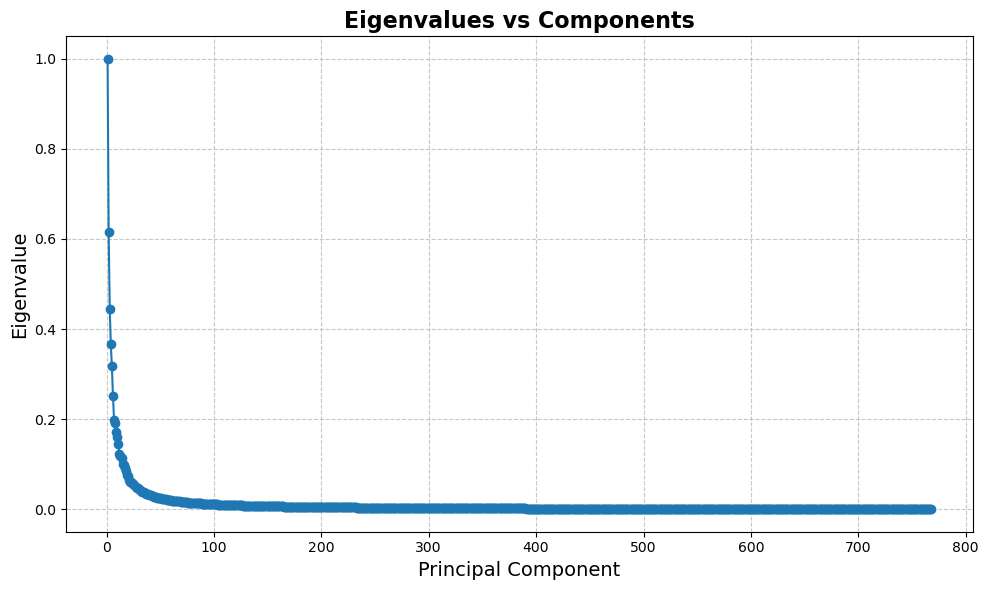

In [38]:
# Center the data (subtract mean from each feature)
centered_data = overview_embeddings_np - np.mean(overview_embeddings_np, axis=0)

# Compute the covariance matrix of the centered data
cov_matrix = np.cov(centered_data, rowvar=False)

# Compute eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices_embeddings = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues in descending order
sorted_eigenvalues_embeddings = eigenvalues[sorted_indices_embeddings]
sorted_eigenvalues_embeddings /= sorted_eigenvalues_embeddings[0]
sorted_eigenvectors_embeddings = eigenvectors[:, sorted_indices_embeddings]

# Plot the sorted eigenvalues versus component indices
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_eigenvalues_embeddings) + 1), sorted_eigenvalues_embeddings, marker='o')
plt.title("Eigenvalues vs Components", fontsize=16, fontweight='bold')
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Eigenvalue", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save or display the plot
plt.savefig("eigenvalues_vs_components_text_data_overview.png", dpi=300)
plt.show()

In [39]:
top_100_eigenvectors_embeddings = sorted_eigenvectors_embeddings[:, :100]
top_100_pca_data_embeddings = np.dot(overview_embeddings_np - np.mean(overview_embeddings_np, axis=0), top_100_eigenvectors_embeddings)


In [40]:

# Reconstruct the data using the top 20 eigenvectors
reconstructed_data = np.dot(top_100_pca_data_embeddings, top_100_eigenvectors_embeddings.T) + np.mean(overview_embeddings_np, axis=0)

# Compute the reconstruction error (Mean Squared Error)
reconstruction_error = np.mean((overview_embeddings_np - reconstructed_data) ** 2)

print("Reconstruction Error For Text Embedding:", reconstruction_error)


Reconstruction Error For Text Embedding: 0.012712659224483216


## PCA for Categorical Data

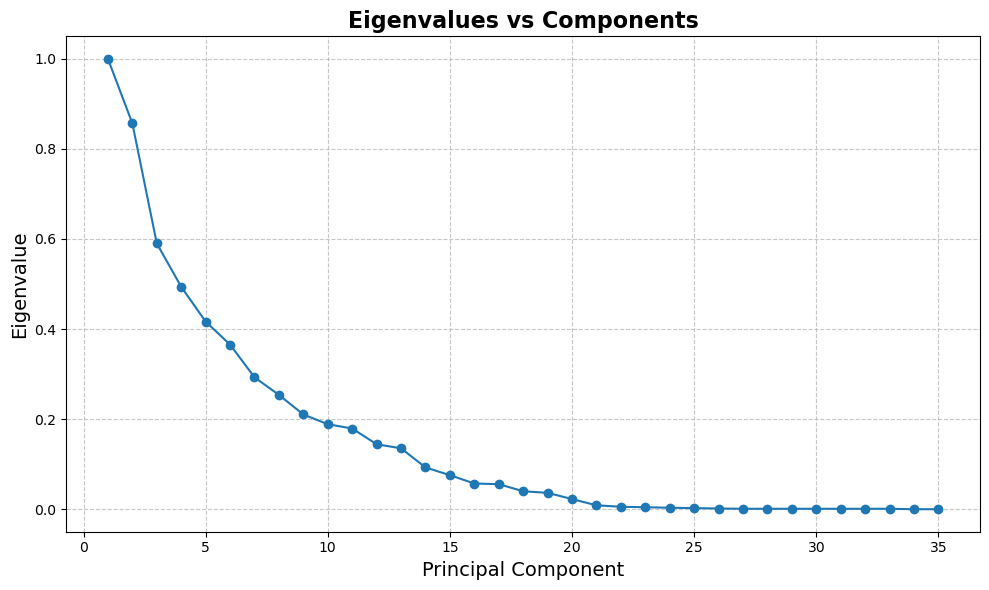

In [41]:
# Center the data (subtract mean from each feature)
centered_data = categorical - np.mean(categorical, axis=0)

# Compute the covariance matrix of the centered data
cov_matrix = np.cov(centered_data, rowvar=False)

# Compute eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of eigenvalues in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvalues /= sorted_eigenvalues[0]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Plot the sorted eigenvalues versus component indices
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o')
plt.title("Eigenvalues vs Components", fontsize=16, fontweight='bold')
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Eigenvalue", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save or display the plot
plt.savefig("eigenvalues_vs_components_categorical.png", dpi=300)
plt.show()

In [42]:
top_30_eigenvectors = sorted_eigenvectors[:, :30]
top_30_pca_data = np.dot(categorical - np.mean(categorical, axis=0), top_30_eigenvectors)


In [43]:

# Reconstruct the data using the top 20 eigenvectors
reconstructed_data = np.dot(top_30_pca_data, top_30_eigenvectors.T) + np.mean(categorical.values, axis=0)

# Compute the reconstruction error (Mean Squared Error)
reconstruction_error = np.mean((categorical - reconstructed_data) ** 2)

print("Reconstruction Error For Categorical:", reconstruction_error)


Reconstruction Error For Categorical: 3.4311513735528765e-05


In [44]:
pca_100 = PCA(n_components=100)
overview_embeddings_pca_100 = pca_100.fit_transform(overview_embeddings_np)

# Check the shape of the reduced data
overview_embeddings_pca_100.shape

(2454, 100)

# Modeling

### Preprocessing
   - Normalized features from numerical, categorical, and text embeddings to ensure uniform scaling.
   - Concatenated these normalized features to create the final feature matrix.

   - Scaled the revenue target variable by dividing it by its mean magnitude to reduce its range and improve model stability.

   - Used 85% of the data for training and 15% for testing.

### Model
1. **Primary Model**: 
   - Applied a Multi-Layer Perceptron (MLP) with:
     - One hidden layer of 128 neurons.
     - Regularization to prevent overfitting.
   - Designed for the regression task of predicting revenue.

2. **Comparison Models**:
   - Evaluated model performance against:
     - Random Forest.
     - Linear Regression.



In [45]:
top_100_pca_data_embeddings /= np.linalg.norm(top_100_pca_data_embeddings,axis = 1, keepdims= True)
top_30_pca_data /= np.linalg.norm(top_30_pca_data,axis = 1, keepdims= True)

In [46]:
np.linalg.norm(top_30_pca_data,axis= 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [47]:

# Convert to numeric and handle missing values
numerical_features = numerical_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert to NumPy array
numerical_features_np = numerical_features.values

scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_np)


# Concatenate embeddings and scaled numerical features
X = np.concatenate([top_30_pca_data,top_100_pca_data_embeddings, numerical_features_scaled], axis=1)
X_scaled = scaler.fit_transform(X)
#X = numerical_features_scaled

# Concatenate embeddings and numerical features
#X = np.concatenate([overview_embeddings_pca_100, numerical_features_np], axis=1)
#X_scaled = scaler.fit_transform(X)

# Check the shape of the combined feature matrix
print(f"Combined feature matrix shape: {X.shape}")

# Extract the target variable
y = movies_imdb['revenue'].values.astype('float64')
y /= 1e8
# Ensure 'y' has the same length as 'X'
print(f"Target variable shape: {y.shape}")



# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

Combined feature matrix shape: (2454, 135)
Target variable shape: (2454,)


In [48]:

# Define the model architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape explicitly
    Dense(128, activation='silu', kernel_regularizer=l2(5e-1)),
    Dense(1)  # Output layer for regression
])

# Compile the model


model.compile(
    optimizer=AdamW(learning_rate=0.002),
    loss='mean_squared_error',
    metrics=['mae']
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Re-train the model with scaled data
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=256,
    verbose=1
)


Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 65.5674 - mae: 1.4419 - val_loss: 48.4451 - val_mae: 1.1113
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.4795 - mae: 1.1272 - val_loss: 32.8581 - val_mae: 0.9180
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 31.2739 - mae: 0.9806 - val_loss: 21.8037 - val_mae: 0.8097
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.7015 - mae: 0.8624 - val_loss: 14.2726 - val_mae: 0.7595
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.5141 - mae: 0.8042 - val_loss: 9.2802 - val_mae: 0.7292
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2184 - mae: 0.7808 - val_loss: 6.1281 - val_mae: 0.7066
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2138 - mae: 0.7629 - val_loss: 4.1616 - val_mae: 0.6943
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5097 - mae: 0.7664 - val_loss: 2.9687 - val_mae: 0.7031
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3682 - mae

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5783 - mae: 0.7853 
Test MAE: 0.7424449324607849


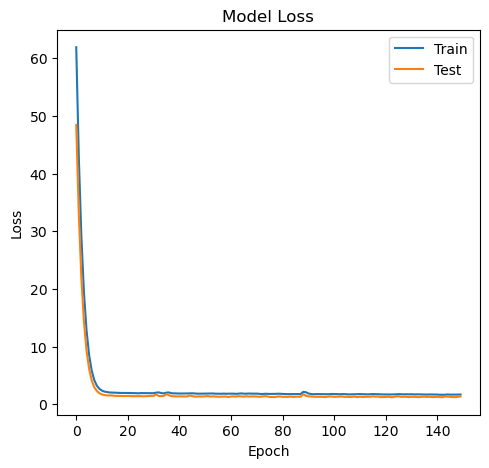

In [50]:
# Evaluate on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae}")

# Plot training & validation loss values


plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('nn_performance.png',dpi=300)



In [51]:
# Make predictions and inverse transform
y_pred = model.predict(X_train)

# Evaluate with actual values
mae_score = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Absolute Error (actual values): {mae_score}")
print(f"R^2 Score: {r2}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error (actual values): 0.7458519197647959
R^2 Score: 0.6376582300260082


In [52]:
# Make predictions and inverse transform
y_pred = model.predict(X_test)

# Evaluate with actual values
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (actual values): {mae_score}")
print(f"R^2 Score: {r2}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error (actual values): 0.7424449509030169
R^2 Score: 0.6167706660134114


## Predict Revenue for a Sample Movie

In [53]:
print("Predicted Movie Rvenue for Pirates of the Caribbean: At World's End: ${}M".format(np.round(model.predict(X_scaled[1,:].reshape(1,-1),verbose=0)[0][0]*100,2)))
print("Predicted Movie Rvenue for Pirates of the Caribbean: At World's End: ${}M".format(np.round(y[1]*100,2))) 

Predicted Movie Rvenue for Pirates of the Caribbean: At World's End: $955.4M
Predicted Movie Rvenue for Pirates of the Caribbean: At World's End: $961.0M


# Random Forest

In [54]:

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MAE: {mae_score}")
print(f"Random Forest R^2 Score: {r2}")


Random Forest MAE: 0.6915741893422764
Random Forest R^2 Score: 0.5875344253106405


# Linear Regression

In [55]:


# Initialize the Kernel Ridge Regression model
krr_model = Ridge(alpha=0.1)

# Train the model
krr_model.fit(X_train, y_train)

# Make predictions
y_pred = krr_model.predict(X_test)


# Evaluate the model
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Kernel Ridge Regression MAE: {mae_score}")
print(f"Kernel Ridge Regression R^2 Score: {r2}")


Kernel Ridge Regression MAE: 0.7836051733753167
Kernel Ridge Regression R^2 Score: 0.5989778561634422


## Feature Importances

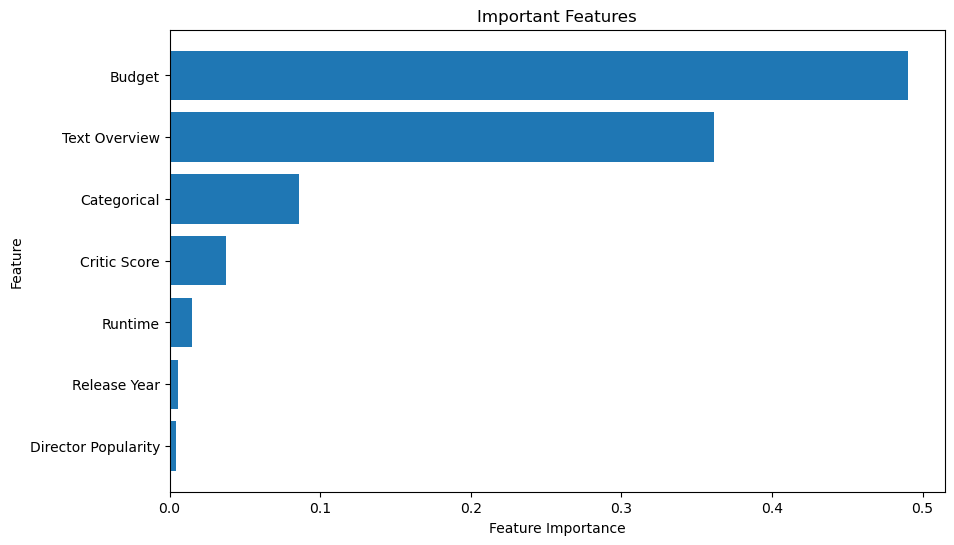

In [56]:
feature_importances = rf_model.feature_importances_

# Create a DataFrame to pair features with their importance

# Calculate summed importance for categorical, text overview, and other features
categorical_importance = np.sum(feature_importances[0:30])  # Sum of importance for categorical features
text_overview_importance = np.sum(feature_importances[30:130])  # Sum of importance for text overview
other_importances = feature_importances[130:]  # Remaining individual feature importances

# Combine them into a single array
combined_importances = np.concatenate([
    [categorical_importance], 
    [text_overview_importance], 
    other_importances
])

# Assign names to the corresponding importance values
feature_groups = ['Categorical', 'Text Overview'] + [
    'Budget', 'Release Year', 'Runtime', 'Critic Score', 'Director Popularity'
]


importance_summary = pd.DataFrame({
    'Feature Group': feature_groups,
    'Importance': combined_importances
})

# Sort by importance for clarity
importance_summary = importance_summary.sort_values(by='Importance', ascending=False)




# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(importance_summary['Feature Group'], importance_summary['Importance'], align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Important Features")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.savefig('feature_importances.png',dpi=300)
plt.show()


## Using only the Top 3 Features in the Model

In [57]:

# Convert to numeric and handle missing values
numerical_features = numerical_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert to NumPy array
numerical_features_np = numerical_features.values

scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_np)


# Concatenate embeddings and scaled numerical features
X = np.concatenate([top_30_pca_data,top_100_pca_data_embeddings, numerical_features_scaled[:,0:1]], axis=1)
X_scaled = scaler.fit_transform(X)
#X = numerical_features_scaled

# Concatenate embeddings and numerical features
#X = np.concatenate([overview_embeddings_pca_100, numerical_features_np], axis=1)
#X_scaled = scaler.fit_transform(X)

# Check the shape of the combined feature matrix
print(f"Combined feature matrix shape: {X.shape}")

# Extract the target variable
y = movies_imdb['revenue'].values.astype('float64')
y /= 1e8
# Ensure 'y' has the same length as 'X'
print(f"Target variable shape: {y.shape}")



# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

Combined feature matrix shape: (2454, 131)
Target variable shape: (2454,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 128)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 63.9665 - mae: 1.2986 - val_loss: 48.0905 - val_mae: 1.0907
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 44.7158 - mae: 1.0321 - val_loss: 32.9808 - val_mae: 0.9401
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 30.5484 - mae: 0.8870 - val_loss: 22.1487 - val_mae: 0.8488
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.9517 - mae: 0.8546 - val_loss: 14.6404 - val_mae: 0.7852
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.8537 - mae: 0.7970 - val_loss: 9.6668 - val_mae: 0.7528
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3090 - mae: 0.7810 - val_loss: 6.4618 - val_mae: 0.7451
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3098 - mae: 0.7739 - val_loss: 4.4663 - val_mae: 0.7406
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6853 - mae: 0.7843 - val_loss: 3.2755 - val_mae: 0.7602
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3645 - mae:

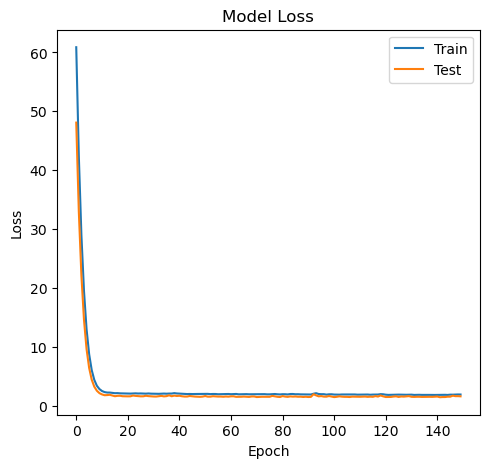

In [58]:

# Define the model architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape explicitly
    Dense(128, activation='silu', kernel_regularizer=l2(5e-1)),
    Dense(1)  # Output layer for regression
])

# Compile the model


model.compile(
    optimizer=AdamW(learning_rate=0.002),
    loss='mean_squared_error',
    metrics=['mae']
)

# Print model summary
model.summary()
# Re-train the model with scaled data
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=256,
    verbose=1
)

# Evaluate on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae}")

# Plot training & validation loss values


plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()



In [59]:
# Make predictions and inverse transform
y_pred = model.predict(X_train)

# Evaluate with actual values
mae_score = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Absolute Error (actual values): {mae_score}")
print(f"R^2 Score: {r2}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Absolute Error (actual values): 0.7903258842809877
R^2 Score: 0.5788542265830946


In [60]:
# Make predictions and inverse transform
y_pred = model.predict(X_test)

# Evaluate with actual values
mae_score = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (actual values): {mae_score}")
print(f"R^2 Score: {r2}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error (actual values): 0.7768663665795252
R^2 Score: 0.5196039863231192


# Classification 


Predicting revenue as a regression task poses significant challenges:
   - Movie revenues span several orders of magnitude, from massive losses to billion-dollar blockbusters.
   - This vast range makes it difficult for regression models to accurately learn and predict such extreme variations.
   - Extremely high-grossing blockbusters and severe losses can dominate the training process, leading to biased models that struggle with mid-range predictions.


To address these challenges, we transform the problem into a classification task:
   - Revenue is categorized into four meaningful classes based on profit ranges:
     - **Large Losses**: Significant financial underperformance.
     - **Break-even/Low Profit**: Moderate financial results.
     - **Moderate Hits**: Successful but not blockbusters.
     - **Blockbusters**: Exceptionally high revenue.
   - Reduces the prediction complexity by focusing on broader profit categories rather than precise values.


In [61]:

# Define custom bins based on movie industry profit ranges
bin_edges = [-float('inf'), -10_000_000, 10_000_000, 100_000_000, float('inf')]
bin_labels = ['Large Losses', 'Break-even/Low Profit', 'Moderate Hits', 'Blockbusters']

# Categorize the profits using pd.cut
movies_imdb['profit_category'] = pd.cut(
    movies_imdb['profit'],
    bins=bin_edges,
    labels=bin_labels
)

# Count the number of movies in each category
category_counts = movies_imdb['profit_category'].value_counts()

# Display the counts
print("Profit categories and their counts:")
print(category_counts)

# Display the category ranges for reference
print("\nCategory ranges:")
for i, (start, end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    print(f"{bin_labels[i]}: {start:,} to {end:,}")


Profit categories and their counts:
profit_category
Moderate Hits            928
Break-even/Low Profit    630
Blockbusters             614
Large Losses             282
Name: count, dtype: int64

Category ranges:
Large Losses: -inf to -10,000,000
Break-even/Low Profit: -10,000,000 to 10,000,000
Moderate Hits: 10,000,000 to 100,000,000
Blockbusters: 100,000,000 to inf


In [62]:
# Encode the target variable if not already numerical
movies_imdb['profit_category_code'] = movies_imdb['profit_category'].astype('category').cat.codes

In [63]:
movies_imdb['profit_category_code'].value_counts()

profit_category_code
2    928
1    630
3    614
0    282
Name: count, dtype: int64

# Classification Modelling

In [64]:

# Check the shape of the combined feature matrix
print(f"Combined feature matrix shape: {X.shape}")

# Extract the target variable
y = movies_imdb['profit_category_code'].values.astype('float64')

# Ensure 'y' has the same length as 'X'
print(f"Target variable shape: {y.shape}")



# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

Combined feature matrix shape: (2454, 131)
Target variable shape: (2454,)


In [65]:
# Define the model architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape explicitly
    Dense(64, activation='silu', kernel_regularizer=l2(5e-1)),
    Dense(4, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.002),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,708 (34.02 KB)

 Trainable params: 8,708 (34.02 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:


# Train the model
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=200,  # Adjust based on your dataset
    batch_size=256,
    verbose=1
)


Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2742 - loss: 41.7590 - val_accuracy: 0.2466 - val_loss: 32.8136
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3180 - loss: 30.3900 - val_accuracy: 0.2927 - val_loss: 23.5225
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3297 - loss: 21.7038 - val_accuracy: 0.3117 - val_loss: 16.5968
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3644 - loss: 15.2737 - val_accuracy: 0.3442 - val_loss: 11.5941
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3738 - loss: 10.6594 - val_accuracy: 0.3631 - val_loss: 8.0786
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4092 - loss: 7.4409 - val_accuracy: 0.3984 - val_loss: 5.6698
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4223 - loss: 5.2360 - val_accuracy: 0.4255 - val_loss: 4.0532
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4336 - loss: 3.7599 - val_accuracy: 0.4472 - val_los

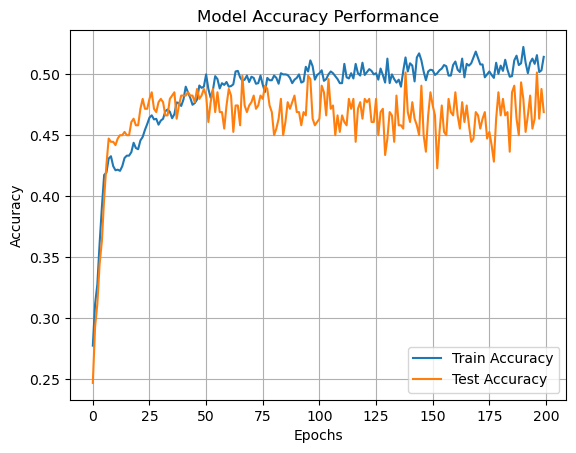

In [67]:
# Plot accuracy performance
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Performance')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
y_train_pred_probs = model.predict(X_train)  # Predictions as probabilities
y_train_pred = y_train_pred_probs.argmax(axis=1)  # Convert probabilities to class indices
# Evaluate the model
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.09      0.17       242
         1.0       0.56      0.41      0.48       540
         2.0       0.47      0.71      0.57       780
         3.0       0.61      0.58      0.59       523

    accuracy                           0.53      2085
   macro avg       0.64      0.45      0.45      2085
weighted avg       0.58      0.53      0.50      2085

Confusion Matrix:
[[ 22  34 141  45]
 [  1 222 284  33]
 [  1 105 556 118]
 [  0  32 190 301]]


In [69]:

# Predict and evaluate
y_pred_probs = model.predict(X_test)  # Predictions as probabilities
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.20      0.03      0.04        40
         1.0       0.48      0.36      0.41        90
         2.0       0.45      0.61      0.52       148
         3.0       0.52      0.55      0.53        91

    accuracy                           0.47       369
   macro avg       0.41      0.38      0.38       369
weighted avg       0.45      0.47      0.44       369

Confusion Matrix:
[[ 1  3 27  9]
 [ 0 32 49  9]
 [ 3 26 90 29]
 [ 1  5 35 50]]


# Random Forest

In [73]:
# Assuming X_train, X_test, y_train, y_test are already defined
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Additional evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        40
         1.0       0.58      0.41      0.48        90
         2.0       0.46      0.74      0.57       148
         3.0       0.68      0.49      0.57        91

    accuracy                           0.52       369
   macro avg       0.43      0.41      0.41       369
weighted avg       0.49      0.52      0.49       369

Accuracy Score:
0.5203252032520326
Confusion Matrix:
[[  0   2  36   2]
 [  0  37  51   2]
 [  0  21 110  17]
 [  0   4  42  45]]
